# Árbol de Decisión — Overfitting vs Good Fit vs Underfitting

**Dataset**: *Banknote Authentication* (binario: 0=auténtico, 1=falso).

- Kaggle (referencia): Bank Note Authentication UCI data. "https://www.kaggle.com/datasets/ritesaluja/bank-note-authentication-uci-data"
- UCI (descarga directa en el código): *Banknote Authentication Data Set*.

**Objetivo didáctico**: entrenar **tres árboles** con distinta complejidad y comparar:
1) **Overfitting** (árbol muy profundo)
2) **Good fit** (profundidad moderada)
3) **Underfitting** (árbol muy poco profundo)

Al final, **escribe tus observaciones** y di **cuál elegirías y por qué**.

Recursos de apoyo: https://4geeks.com/es/lesson/arboles-de-decision
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import export_text


## 1) Cargar dataset y quedarnos con 2 features
Usaremos **variance** y **skewness** para poder dibujar regiones de decisión fácilmente.

In [21]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
cols = ['variance','skewness','curtosis','entropy','target']
df = pd.read_csv(url, header=None, names=cols)

X = df[['variance','skewness']].values
y = df['target'].values
df.head()

,variance,skewness,curtosis,entropy,target
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## 2) División train/test

In [22]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape

((1029, 2), (343, 2))

## 3) Función para dibujar regiones de decisión

In [23]:
def plot_decision_regions(X, y, clf, title='Decision regions'):
    x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
    y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(5,4))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, s=25)
    plt.title(title)
    plt.xlabel('variance')
    plt.ylabel('skewness')
    plt.tight_layout()
    plt.show()


## 4) Entrenar tres árboles con distinta complejidad

### 4.1 Overfitting (árbol sobreajustado)

Accuracy train: 1.0
Accuracy test : 0.918
Confusion matrix (test):
 [[175  16]
 [ 12 140]]


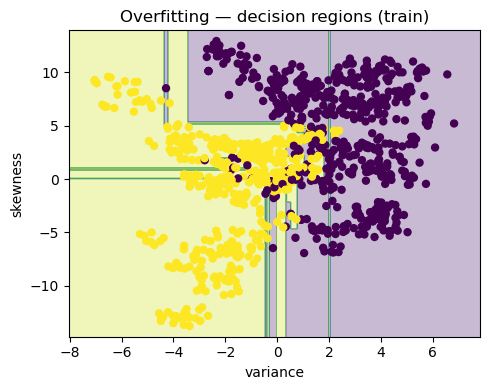

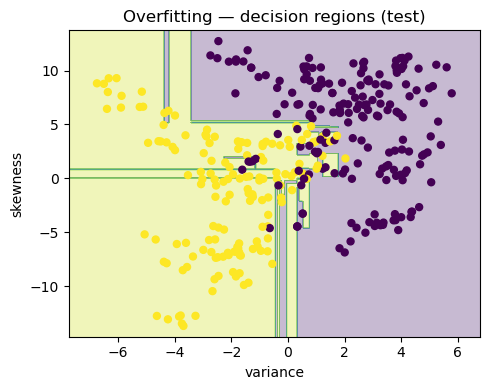

|--- feature_0 <= 0.77
|   |--- feature_1 <= 5.16
|   |   |--- feature_0 <= 0.32
|   |   |   |--- feature_0 <= -0.46
|   |   |   |   |--- feature_1 <= 0.05
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_1 >  0.05
|   |   |   |   |   |--- feature_1 <= 0.10
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_1 >  0.10
|   |   |   |   |   |   |--- feature_1 <= 2.02
|   |   |   |   |   |   |   |--- feature_1 <= 1.90
|   |   |   |   |   |   |   |   |--- feature_1 <= 0.83
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_1 >  0.83
|   |   |   |   |   |   |   |   |   |--- feature_1 <= 0.87
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_1 >  0.87
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= -1.14
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  -1.14
|   |   |   

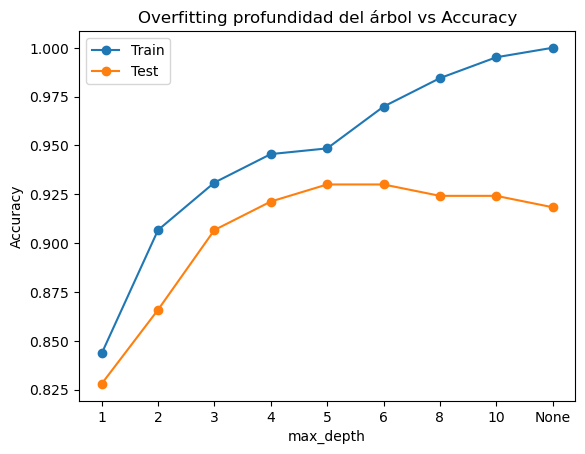

Accuracy train: 0.948
Accuracy test : 0.93
Confusion matrix (test):
 [[177  14]
 [ 10 142]]


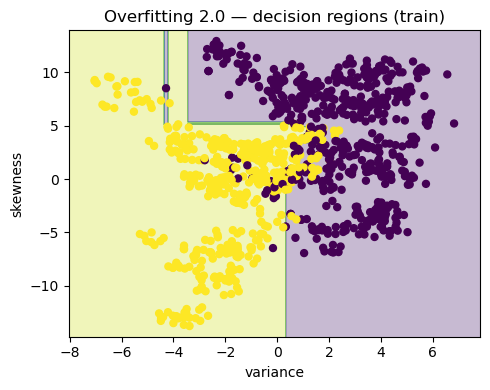

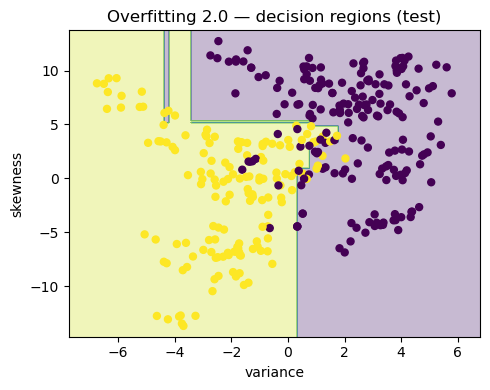

In [24]:
over = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=None, min_samples_leaf=1)
over.fit(X_train, y_train)
y_pred_tr = over.predict(X_train)
y_pred_te = over.predict(X_test)
acc_tr = accuracy_score(y_train, y_pred_tr)
acc_te = accuracy_score(y_test, y_pred_te)
cm_over = confusion_matrix(y_test, y_pred_te)
print('Accuracy train:', round(acc_tr,3))
print('Accuracy test :', round(acc_te,3))
print('Confusion matrix (test):\n', cm_over)
plot_decision_regions(X_train, y_train, over, title='Overfitting — decision regions (train)')
plot_decision_regions(X_test, y_test, over, title='Overfitting — decision regions (test)')

########

tree_text = export_text(over)
print(tree_text)

########
depths = [1,2,3,4,5,6,8,10,None]
train_scores, test_scores = [], []
for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure()
plt.plot([str(d) for d in depths], train_scores, marker="o", label="Train")
plt.plot([str(d) for d in depths], test_scores, marker="o", label="Test")
plt.title("Overfitting profundidad del árbol vs Accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##############
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)
train_scores.append(model.score(X_train, y_train))
test_scores.append(model.score(X_test, y_test))

over = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5, min_samples_leaf=1)
over.fit(X_train, y_train)
y_pred_tr = over.predict(X_train)
y_pred_te = over.predict(X_test)
acc_tr = accuracy_score(y_train, y_pred_tr)
acc_te = accuracy_score(y_test, y_pred_te)
cm_over = confusion_matrix(y_test, y_pred_te)
print('Accuracy train:', round(acc_tr,3))
print('Accuracy test :', round(acc_te,3))
print('Confusion matrix (test):\n', cm_over)
plot_decision_regions(X_train, y_train, over, title='Overfitting 2.0 — decision regions (train)')
plot_decision_regions(X_test, y_test, over, title='Overfitting 2.0 — decision regions (test)')


### 4.2 Good fit (profundidad moderada)

Accuracy train: 0.931
Accuracy test : 0.907
Confusion matrix (test):
 [[170  21]
 [ 11 141]]


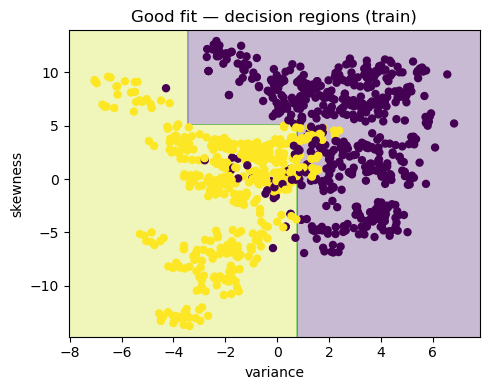

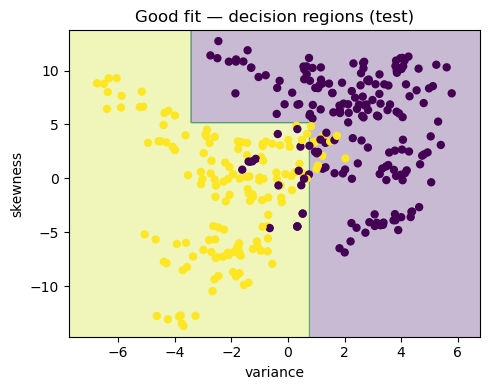

|--- feature_0 <= 0.77
|   |--- feature_1 <= 5.16
|   |   |--- feature_0 <= 0.32
|   |   |   |--- class: 1
|   |   |--- feature_0 >  0.32
|   |   |   |--- class: 1
|   |--- feature_1 >  5.16
|   |   |--- feature_0 <= -3.43
|   |   |   |--- class: 1
|   |   |--- feature_0 >  -3.43
|   |   |   |--- class: 0
|--- feature_0 >  0.77
|   |--- feature_0 <= 1.79
|   |   |--- feature_1 <= 4.90
|   |   |   |--- class: 0
|   |   |--- feature_1 >  4.90
|   |   |   |--- class: 0
|   |--- feature_0 >  1.79
|   |   |--- feature_0 <= 2.39
|   |   |   |--- class: 0
|   |   |--- feature_0 >  2.39
|   |   |   |--- class: 0



In [27]:
good = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=3, min_samples_leaf=5)
good.fit(X_train, y_train)
y_pred_tr = good.predict(X_train)
y_pred_te = good.predict(X_test)
acc_tr = accuracy_score(y_train, y_pred_tr)
acc_te = accuracy_score(y_test, y_pred_te)
cm_good = confusion_matrix(y_test, y_pred_te)
print('Accuracy train:', round(acc_tr,3))
print('Accuracy test :', round(acc_te,3))
print('Confusion matrix (test):\n', cm_good)
plot_decision_regions(X_train, y_train, good, title='Good fit — decision regions (train)')
plot_decision_regions(X_test, y_test, good, title='Good fit — decision regions (test)')

########

tree_text = export_text(good)
print(tree_text)


### 4.3 Underfitting (árbol demasiado simple)

Accuracy train: 0.844
Accuracy test : 0.828
Confusion matrix (test):
 [[143  48]
 [ 11 141]]


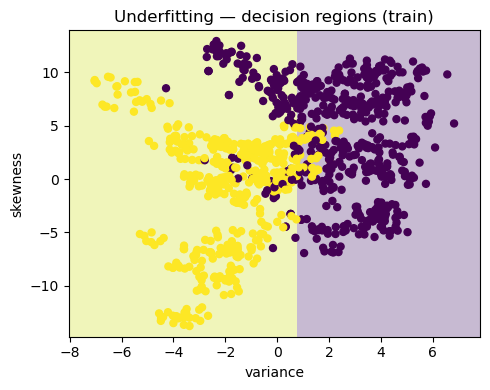

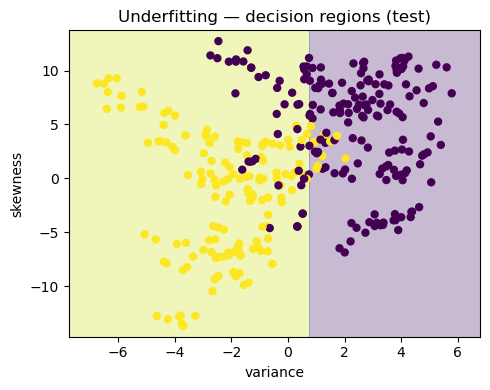

|--- feature_0 <= 0.77
|   |--- class: 1
|--- feature_0 >  0.77
|   |--- class: 0



In [26]:
under = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1)
under.fit(X_train, y_train)
y_pred_tr = under.predict(X_train)
y_pred_te = under.predict(X_test)
acc_tr = accuracy_score(y_train, y_pred_tr)
acc_te = accuracy_score(y_test, y_pred_te)
cm_under = confusion_matrix(y_test, y_pred_te)
print('Accuracy train:', round(acc_tr,3))
print('Accuracy test :', round(acc_te,3))
print('Confusion matrix (test):\n', cm_under)
plot_decision_regions(X_train, y_train, under, title='Underfitting — decision regions (train)')
plot_decision_regions(X_test, y_test, under, title='Underfitting — decision regions (test)')
tree_text = export_text(under)
print(tree_text)


## 5) Conclusión — Recuadro para tus observaciones
- **Overfitting**: ¿qué observas en entrenamiento vs test?
- **Good fit**: ¿cómo se comparan las fronteras de decisión entre clases? ¿y las métricas?
- **Underfitting**: ¿qué patrón ves? ¿qué está pasando con la frontera?

**¿Cuál es el mejor y por qué?**

> Escribe aquí tu conclusión final.